<h1 align="center">Deep Learning - Master in Deep Learning of UPM</h1> 

**IMPORTANTE**

Usaremos PyTorch Lightning para unificar arquitectura y lógica de entrenamiento en un único módulo:

In [1]:
# %%capture
# !pip install pytorch_lightning

En esta sesión implementaremos _from scratch_ un Transformer utilizando únicamente `PyTorch` para construir la arquitectura y `Lightning` para el entrenamiento.

In [2]:
import torch
import pytorch_lightning

# Manejo de datos y Tokenizado
---

## Carga del Dataset

En este bloque de código, cargamos el conjunto de datos que utilizaremos para entrenar. Podéis elegir entre tres corpus: *Shakespeare*, *Rick and Morty* o *Tarantino*.

In [3]:
data_path = 'data/shakespeare.txt'
# data_path = 'data/rick_and_morty.txt'
# data_path = 'data/tarantino.txt'

with open(data_path, 'r') as f:
    data = f.read()

print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## Tokenizador

In [4]:
class CharTokenizer:
    def __init__(self):
        self.vocab_size = 0
        self.str2tok = {}
        self.tok2str = {}

    @classmethod
    def from_data(cls, data, add_pad_token=True):
        tokenizer = cls()

        vocab = sorted(list(set(data)))
        if add_pad_token:
            vocab.insert(0, '<pad>')

        tokenizer.vocab_size = len(vocab)

        tokenizer.str2tok = {c: t for t, c in enumerate(vocab)}
        tokenizer.tok2str = {t: c for t, c in enumerate(vocab)}

        return tokenizer

    def encode(self, text):
        _encode = lambda text: [self.str2tok[c] for c in text]

        if isinstance(text, list):
            return [_encode(s) for s in text]
        else:
            return _encode(text)
    
    def decode(self, tokens):
        return ''.join([self.tok2str[t] for t in tokens])
    
    @property
    def pad_token(self):
        return self.str2tok['<pad>']

## Dataset

In [5]:
class CharDatasetForAutoregression(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, seq_len=512, windowed=False):
        self.data = data
        self.tokenizer = tokenizer
        self.seq_len = seq_len + 1 # +1 for target
        self.windowed = windowed

    def __len__(self):
        return len(self.data) - self.seq_len + 1 if not self.windowed else len(self.data) // self.seq_len + 1
    
    def __getitem__(self, idx):
        start_idx, end_idx = (idx, idx+self.seq_len) if not self.windowed else (idx*self.seq_len,idx*self.seq_len+self.seq_len)

        input_ids = self.tokenizer.encode(self.data[start_idx:end_idx])
        return input_ids

## Función Collate

In [6]:
def pad_sequences(sequences, pad_token=0, pad_site='right', return_mask=False):
    max_seq_len = max([len(seq) for seq in sequences])

    def pad_sequence(seq):
        pad_len = (max_seq_len - len(seq))
        pad = [pad_token] * pad_len
        if pad_site == 'right':
            pad_seq = seq + pad
            pad_mask = [1] * len(seq) + [0] * pad_len
            return pad_seq, pad_mask
        elif pad_site == 'left':
            pad_seq = pad + seq
            pad_mask = [0] * pad_len + [1] * len(seq)
            return pad_seq, pad_mask
        else:
            raise ValueError(f"Invalid padding site: {pad_site}. Consider using 'right' or 'left'.")
    
    pad_seqs, pad_masks = [], []
    for seq in sequences:
        pad_seq, pad_mask = pad_sequence(seq)
        pad_seqs.append(pad_seq)
        pad_masks.append(pad_mask)

    return (pad_seqs, pad_masks) if return_mask else pad_seqs
    
class CollatorForAutoregression:
    def __init__(self, pad_token=0):
        self.pad_token = pad_token
    
    def __call__(self, sequences):
        context, mask = pad_sequences(sequences, pad_token=self.pad_token, return_mask=True)

        context, mask = torch.tensor(context), torch.tensor(mask)

        input_ids, att_mask = context[:, :-1], mask[:, :-1] # [:seq_len-1] -> batch_size x seq_len
        target_ids, target_att_mask = context[:, 1:], mask[:, 1:] # [1:seq_len] -> batch_size x seq_len

        return input_ids, att_mask, target_ids, target_att_mask

## DataModule

In [7]:
class CharDataModuleForAutoregression(pytorch_lightning.LightningDataModule):
    def __init__(self, data, max_seq_len=512, batch_size=64, train_size=.8, windowed=False, multiprocess_config={}):
        super().__init__()
        self.data = data
        self.tokenizer = CharTokenizer.from_data(data)
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.train_size = train_size
        self.windowed = windowed

        self.multiprocess_config = multiprocess_config
        
    def setup(self, stage=None):
        if stage == 'fit':
            dataset = CharDatasetForAutoregression(self.data, self.tokenizer, seq_len=self.max_seq_len, windowed=self.windowed)

            train_size = int(len(dataset) * self.train_size)
            val_size = len(dataset) - train_size
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
            self.collate_fn = CollatorForAutoregression(pad_token=self.tokenizer.pad_token)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True, **self.multiprocess_config)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, **self.multiprocess_config)

# Transformer
---

## Encoding Posicional

La codificación sinusoidal permite que el modelo entienda relaciones relativas de manera eficiente, sin importar la longitud de la oración. Esto es clave porque el lenguaje se basa en patrones de relación más que en posiciones absolutas. Si un Transformer aprende que **el verbo suele estar después del sujeto, esta relación se mantendrá sin importar la posición exacta en la oración.** 

Si tomamos la ecuación del Positional Encoding:

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

Podemos ver que si queremos calcular el encoding de una posición desplazada \( pos+k \):

$$
PE(pos + k, 2i) = \sin\left(\frac{pos + k}{10000^{2i/d_{\text{model}}}}\right)
$$

$$
PE(pos + k, 2i+1) = \cos\left(\frac{pos + k}{10000^{2i/d_{\text{model}}}}\right)
$$

Usando propiedades trigonométricas como:

$$
\sin(A + B) = \sin A \cos B + \cos A \sin B
$$

$$
\cos(A + B) = \cos A \cos B - \sin A \sin B
$$

Esto nos permite expresar $ PE_{pos+k} $ **como una combinación lineal de $ PE_{pos} $**.

In [8]:
class SinusoidalPositionalEncoding(torch.nn.Module):
    def __init__(self, max_seq_len, d_model, freq=10_000):
        super().__init__()
        pe = torch.zeros(max_seq_len, d_model)

        pos = torch.arange(0, max_seq_len).unsqueeze(-1) # (max_seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(freq)) / d_model)) # e^(2i * -(log(freq) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term) # PE(pos, 2i) = sin(pos / freq^(2i/d_model))
        pe[:, 1::2] = torch.cos(pos * div_term) # PE(pos, 2i+1) = cos(pos / freq^(2i/d_model))

        pe = pe.unsqueeze(0) # add batch dimension

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

# Parámetros iniciales
max_seq_len = 100  # Número de posiciones en la oración
d_model = 16       # Dimensiones del embedding
freq = 10_000  # Frecuencia base

# Función para graficar interactivamente
def plot_positional_encoding(d=0, freq=10_000):
    pos = np.arange(max_seq_len) # seq_len
    pe = SinusoidalPositionalEncoding(max_seq_len, d_model, freq=freq).pe.squeeze(0).numpy() # seq_len x d_model

    plt.figure(figsize=(10, 3))

    # Graficar la dimensión seleccionada
    plt.plot(pos, pe[:, d], label=f'Sin d={d}', color='b') # sin(pos / freq^(2i/d_model))
    plt.plot(pos, pe[:, d+1], linestyle="dashed", label=f'Cos d={d+1}', color='r') # cos(pos / freq^(2i/d_model))
    
    plt.xlabel("Posición en la secuencia")
    plt.ylabel("Valor de Encoding")
    plt.title(f"Positional Encoding para dimensión {d} y {d+1}")
    plt.legend()
    plt.show()

# Interfaz interactiva con sliders
interact(plot_positional_encoding, 
         d=widgets.IntSlider(min=0, max=d_model-1, step=2, value=0, description="Dimensión"),
         freq=widgets.IntSlider(min=1000, max=20000, step=1000, value=freq, description="Frecuencia"));



interactive(children=(IntSlider(value=0, description='Dimensión', max=15, step=2), IntSlider(value=10000, desc…

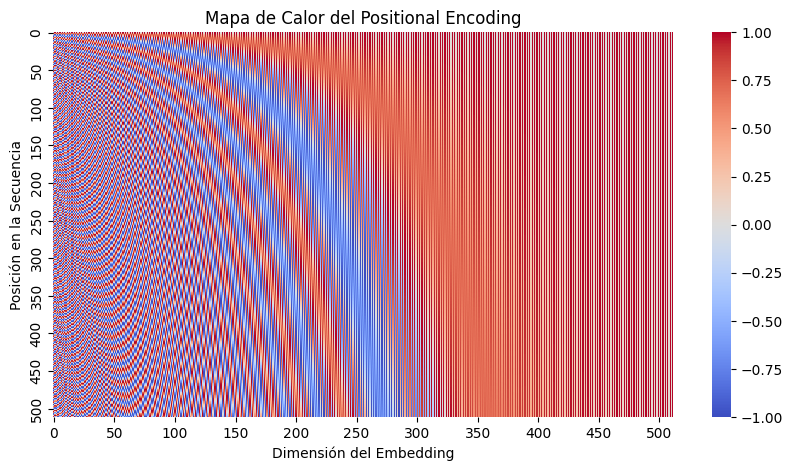

In [10]:
import seaborn as sns

# Parámetros iniciales
max_seq_len = 512  # Número de posiciones en la oración
d_model = 512      # Dimensiones del embedding
freq = 10_000  # Frecuencia base


pos = np.arange(max_seq_len) # seq_len
pe = SinusoidalPositionalEncoding(max_seq_len, d_model, freq=freq).pe.squeeze(0).numpy() # seq_len x d_model

# Graficar Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(pe, cmap="coolwarm", xticklabels=50, yticklabels=50)
plt.xlabel("Dimensión del Embedding")
plt.ylabel("Posición en la Secuencia")
plt.title("Mapa de Calor del Positional Encoding")
plt.show()


## Scaled Dot Product Attention

En el siguiente bloque de código se puede apreciar que si escalamos los valores, la función softmax tiende a la función de one-hot encoding.

In [25]:
x = torch.tensor([[1, 2, 3], [2, 3, 6]], dtype=torch.float32)

print(torch.softmax(x, dim=-1))

scale_by = 100

print(torch.softmax(x * scale_by, dim=-1))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0171, 0.0466, 0.9362]])
tensor([[0.0000e+00, 3.7835e-44, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])


Creemos nuestra propia función softmax y comprobemos que funciona.

In [27]:
def softmax(x, dim=-1):
    # TODO: Implementar softmax
    return ...

x = torch.randn(2, 3)
assert torch.allclose(softmax(x), torch.softmax(x, dim=-1))

A continuación creemos nuesta propia _scaeled dot product attention_.

In [59]:
def scaled_dot_product_attention(q, k, v, att_mask=None, is_causal=False, p_drop=0.0):
    seq_len, d_k = k.size(-2), k.size(-1) # sequence length, head dimension
    scale_factor = ... # scale factor for softmax
    att_scores = ... # batch_size x num_heads x seq_len x seq_len

    if is_causal:
        # TODO: Aplicar máscara causal
        # Pista: Usar torch.tril en combinación con tensor.masked_fill
        ...
    
    if att_mask is not None:
        att_scores = att_scores.masked_fill(att_mask.unsqueeze(1).unsqueeze(2) == 0, float('-inf'))

    att_scores = softmax(att_scores, dim=-1)
    att_scores = ... # dropout
    out = ... # multiplicar att_scores por v
    return out

## Multi-Head Self Attention

In [28]:
# TODO: Implementar MultiHeadSelfAttention
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = ...

        self.q_proj = ... # Proyección de queries
        self.k_proj = ... # Proyección de keys
        self.v_proj = ... # Proyección de values

        self.out_proj = ... # Proyección de salida

    def forward(self, x, att_mask=None, is_causal=False):
        batch_size, seq_len = x.size(0), x.size(1)
        # TODO: Proyectar queries, keys y values
        q = ... # batch_size x seq_len x d_model
        k = ... # batch_size x seq_len x d_model
        v = ... # batch_size x seq_len x d_model

        # TODO: Dividir en múltiples cabezas
        q = ... # batch_size x seq_len x num_heads x head_size
        k = ... # batch_size x seq_len x num_heads x head_size
        v = ... # batch_size x seq_len x num_heads x head_size

        # TODO: Transponer para multiplicar asegurando compatibilidad de dimensiones
        q = ... # batch_size x num_heads x seq_len x head_size
        k = ... # batch_size x num_heads x seq_len x head_size
        v = ... # batch_size x num_heads x seq_len x head_size

        att = scaled_dot_product_attention(q, k, v, att_mask=att_mask, is_causal=is_causal) # batch_size x num_heads x seq_len x head_size

        # TODO: Combinar cabezas (quizás necesites transponer antes...)
        att = ... # batch_size x seq_len x num_heads x head_size
        att = ... # batch_size x seq_len x d_model
        return self.out_proj(att) # batch_size x seq_len x d_model

In [ ]:
# Comprobar que la implementación es correcta
mhsa = MultiHeadSelfAttention(d_model=512, num_heads=8)
x = torch.randn(2, 512, 512)
att = mhsa(x)
assert att.size() == (2, 512, 512)

## Position-Wise Feed Forward

In [13]:
# TODO: Implementar Position-WiseFeedForward
class PositionWiseFFN(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()

        self.linear_1 = ... # Capa lineal 1
        self.linear_2 = ... # Capa lineal 2

        self.act = torch.nn.ReLU() # Función de activación

    def forward(self, x):
        x = ... # batch_size x seq_len x d_ff
        x = ... # aplicar activación
        x = ... # batch_size x seq_len x d_model
        return x # batch_size x seq_len x d_model

## Capa Transformer

In [29]:
class TransformerLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, p_drop=0.0):
        super().__init__()

        self.mhsa = MultiHeadSelfAttention(d_model, num_heads)
        self.pwff = PositionWiseFFN(d_model, d_ff)

        self.dropout = torch.nn.Dropout(p_drop)
        self.layer_norm_mhsa = torch.nn.LayerNorm(d_model)
        self.layer_norm_pwff = torch.nn.LayerNorm(d_model)

    def forward(self, x, att_mask=None, is_causal=False):
        # TODO: Codificar la función forward de una capa Transformer
        ...

        return x

## Transformer

In [30]:
class Transformer(torch.nn.Module):
    def __init__(self, 
                 d_model        : int,          # transformer hidden dimension
                 num_heads      : int,          # number of heads in multi-head attention
                 num_layers     : int,          # number of transformer layers
                 d_ff           : int,          # pos-wise feed-forward hidden dimension
                 p_drop         : float = 0.1,  # dropout probability
                 is_causal      : bool = False  # causal attention mask
                ):
        super().__init__()
        self.transformer_layers = torch.nn.ModuleList([TransformerLayer(d_model, num_heads, d_ff, p_drop) for _ in range(num_layers)])
        self.is_causal = is_causal

    def forward(self, x, att_mask=None):
        for layer in self.transformer_layers:
            x = layer(x, att_mask=att_mask, is_causal=self.is_causal)
        return x

## Transformer Encoder y Transformer Decoder

In [31]:
class TransformerEncoderOnly(torch.nn.Module):
    def __init__(self, 
                 d_model        : int,                                  # transformer hidden dimension
                 num_heads      : int,                                  # number of heads in multi-head attention
                 num_layers     : int,                                  # number of transformer layers
                 d_ff           : int,                                  # pos-wise feed-forward hidden dimension
                 max_seq_len    : int,                                  # maximum sequence length
                 vocab_size     : int,                                  # vocabulary size
                 p_drop         : float = 0.1,                          # dropout probability
                 pos_enc                = SinusoidalPositionalEncoding  # positional encoding type
                ):
        super().__init__()

        self.emb = torch.nn.Embedding(vocab_size, d_model)
        self.pos_enc = pos_enc(max_seq_len, d_model)

        self.body = Transformer(d_model, num_heads, num_layers, d_ff, p_drop)

        self.dropout = torch.nn.Dropout(p_drop)

    def forward(self, input_ids, att_mask=None):
        x = self.dropout(self.pos_enc(self.emb(input_ids)))
        return self.body(x, att_mask=att_mask)
    
class TransformerDecoderOnly(torch.nn.Module):
    def __init__(self, 
                 d_model        : int,                                  # transformer hidden dimension
                 num_heads      : int,                                  # number of heads in multi-head attention
                 num_layers     : int,                                  # number of transformer layers
                 d_ff           : int,                                  # pos-wise feed-forward hidden dimension
                 max_seq_len    : int,                                  # maximum sequence length
                 vocab_size     : int,                                  # vocabulary size
                 p_drop         : float = 0.1,                          # dropout probability
                 pos_enc                = SinusoidalPositionalEncoding  # positional encoding type
                ):
        super().__init__()

        self.emb = torch.nn.Embedding(vocab_size, d_model)
        self.pos_enc = pos_enc(max_seq_len, d_model)

        self.transformer = Transformer(d_model, num_heads, num_layers, d_ff, p_drop, is_causal=True)

        self.dropout = torch.nn.Dropout(p_drop)

    def forward(self, input_ids, att_mask=None):
        x = self.dropout(self.pos_enc(self.emb(input_ids)))
        return self.transformer(x, att_mask=att_mask)

# Transformer Para Modelado Causal del Lenguaje (Autorregresión)
---

## Arquitectura

In [32]:
class TransformerForCausalLM(torch.nn.Module):
    def __init__(self, 
                 d_model        : int,                                  # transformer hidden dimension
                 num_heads      : int,                                  # number of heads in multi-head attention
                 num_layers     : int,                                  # number of transformer layers
                 d_ff           : int,                                  # pos-wise feed-forward hidden dimension
                 max_seq_len    : int,                                  # maximum sequence length
                 vocab_size     : int,                                  # vocabulary size
                 p_drop         : float = 0.1,                          # dropout probability
                 pos_enc                = SinusoidalPositionalEncoding  # positional encoding type
                ):
        super().__init__()

        self.body = TransformerDecoderOnly(d_model, num_heads, num_layers, d_ff, max_seq_len, vocab_size, p_drop, pos_enc)
        self.head = torch.nn.Linear(d_model, vocab_size)

    def forward(self, input_ids, att_mask=None):
        x = self.body(input_ids, att_mask=att_mask)
        return self.head(x)

## Módulo Lightning

In [33]:
class CausalLMModule(pytorch_lightning.LightningModule):
    def __init__(self, 
                 d_model        : int,                                  # transformer hidden dimension
                 num_heads      : int,                                  # number of heads in multi-head attention
                 num_layers     : int,                                  # number of transformer layers
                 d_ff           : int,                                  # pos-wise feed-forward hidden dimension
                 max_seq_len    : int,                                  # maximum sequence length
                 vocab_size     : int,                                  # vocabulary size
                 p_drop         : float = 0.1,                          # dropout probability
                 pos_enc                = SinusoidalPositionalEncoding, # positional encoding type
                 optim_params   : dict  = {'lr': 1e-4}                  # optimizer parameters
                 ):
        super().__init__()
        self.save_hyperparameters()
        self.optim_params = optim_params
        self.model = TransformerForCausalLM(d_model, num_heads, num_layers, d_ff, max_seq_len, vocab_size, p_drop, pos_enc)

    def forward(self, input_ids, att_mask=None):
        return self.model(input_ids, att_mask)
    
    def _step(self, batch):
        input_ids, att_mask, target_ids, target_att_mask = batch
        logits = self(input_ids, att_mask)
        
        batch_size, seq_len, vocab_size = logits.shape

        logits = logits.view(batch_size * seq_len, vocab_size) # (batch_size * seq_len) x vocab_size
        target_ids = target_ids.reshape(batch_size * seq_len) # (batch_size * seq_len)

        loss = torch.nn.functional.cross_entropy(logits, target_ids, reduction='none') # (batch_size * seq_len)
        target_att_mask = target_att_mask.view(-1) / target_att_mask.sum() # (batch_size * seq_len) normalized for averaging
        return (loss * target_att_mask).sum() # sum up the loss and normalize by the number of non-padding tokens
    
    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), **self.optim_params)
    
    def configure_callbacks(self):
        return super().configure_callbacks() + [pytorch_lightning.callbacks.ModelCheckpoint(monitor='val_loss', mode='min')]

## Entrenamiento

In [34]:
# TransformerForCausalLM params
d_model = 128
num_heads = 8
num_layers = 8
d_ff = 512

# DataModule params
batch_size = 64
max_seq_len = 256
train_size = .8
multiprocess_config = dict(num_workers=16, prefetch_factor=4, pin_memory=True)
windowed = True

# Training params
optimizer_params = dict(lr=3e-4, weight_decay=1e-2)
max_epochs = 50
max_steps = 100_000
val_check_interval = 100

data_module = CharDataModuleForAutoregression(data, max_seq_len=max_seq_len, train_size=train_size, batch_size=batch_size, windowed=windowed, multiprocess_config=multiprocess_config)
module = CausalLMModule(d_model=d_model, num_heads=num_heads, num_layers=num_layers, d_ff=d_ff, max_seq_len=max_seq_len, vocab_size=data_module.tokenizer.vocab_size, optim_params=optimizer_params)
trainer = pytorch_lightning.Trainer(max_epochs=max_epochs, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, data_module)

## Sampling e Inferencia

In [ ]:
def greedy_decoding(logits):
    # logits: (batch_size, vocab_size)
    return logits.argmax(dim=-1)

def sampling_decoding(logits):
    # logits: (batch_size, vocab_size)
    return torch.multinomial(torch.nn.functional.softmax(logits, dim=-1), num_samples=1)

def complete_text(
    decoding_fn,
    text,
    tokenizer,
    model,
    num_completions=3,
    max_len=128,
):
    device = next(model.parameters()).device
    for _ in range(num_completions):
        encoded_text = tokenizer.encode(text)[-max_len:]  # NOTE: Truncate the text! The model was
                                                          # trained with a maximum length, and will 
                                                          # break down if the input is longer than that.
                                                          
        encoded_text = torch.tensor(encoded_text).unsqueeze(0).to(device)
        attention_mask = torch.tensor([[1] * len(encoded_text[0])]).to(device)

        with torch.no_grad():
            output = model(encoded_text, attention_mask)  # (1, seq_len, vocab_size)
            output = output[:, -1, :]  # (1, vocab_size)

            next_tokens = decoding_fn(output)  # (1, 1)

            predicted_char = tokenizer.tok2str[next_tokens.item()]

        text += predicted_char

    return text

In [ ]:
MODEL_CHOICE = 'rick_and_morty'
max_seq_len = 128

model = CausalLMModule.load_from_checkpoint(f'{MODEL_CHOICE}.ckpt')

with open(f'data/{MODEL_CHOICE}.txt', 'r') as f:
    data = f.read()

tokenizer = CharTokenizer.from_data(data)


text = "RICK: "
completed_text = complete_text(sampling_decoding, text, tokenizer, model, num_completions=1000, max_len=max_seq_len)
print(completed_text)